<center>Progetto realizzato da Elena Curti (matr. 185431)

# Sentiment analysis – Amazon reviews
</center>

## Introduzione
... realizzato con MongoDB. richiesto python 3.6 - 3.10. ... 


In [1]:
# !pip install happiestfuntokenizing xgboost


In [2]:
import nltk
import random
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.util import mark_negation, extract_unigram_feats
from nltk.corpus import wordnet as wn
from pymongo import MongoClient
from happiestfuntokenizing.happiestfuntokenizing import Tokenizer
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer
from nltk.sentiment.util import demo_liu_hu_lexicon
from io import StringIO
import sys

client = MongoClient('192.168.202.128', 27017)      # TODO mettere localhost
DATABASE = client.test

In [3]:
import os, sys

class HiddenPrints:
    """ Classe usata per evitare print di alcune funzioni """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [4]:
def get_train_test_data_target(reviews):
    classi = list(set(list({x[1] for x in reviews})))
    
    # Creo un dizionario con chiavi le classi e valori una lista di indici delle review di tale classe
    diz_classe_indice = {c:[] for c in classi}
    cont = 0 
    for (r,c) in reviews:
        diz_classe_indice[c].append(cont)
        cont += 1
    
    # Inserisco nel train set e nel test set un numero 
    trainSet = []
    testSet = []
    for (c, indici) in diz_classe_indice.items():
        indexes = random.sample(indici, len(indici))
        int_index = int(len(indici)/2)
        trainSet += [reviews[i] for i in indexes[:int_index]] 
        testSet += [reviews[i] for i in indexes[int_index:]]
    
    train_data, train_target = list(map(list, zip(*trainSet)))
    test_data, test_target = list(map(list, zip(*testSet)))
    return train_data, train_target, test_data, test_target

    
def getReviewData(lista_overall, limite=500, field="reviewText", funzione_tokenize=None):
    reviews = []
    for overall in lista_overall:
        # for review in DATABASE.reviews.find({"overall": overall}).limit(limite):
        for review in DATABASE.reviews.aggregate([
            {'$match' :{"overall": overall}},  
            { '$match': { '$expr': { '$lt': [0.5, {'$rand': {} } ] } } }, 
            {'$limit' : limite}]):
            if funzione_tokenize == None:
                reviews.append((review[field],str(overall))) 
            else:
                reviews.append(([i.lower() for i in funzione_tokenize(review[field])],str(overall))) 
            
    # random.shuffle(reviews) 
    return reviews  
   
def get_classifier_and_mean_accuracy(lista_overall, limite=500,  funzione_filtra_reviews=lambda x:x, feat_extractor=None,  **kwargs):
    """Questa funzione ritorna il classifier e la relativa accuracy media (test eseguiti su 50 run).  
    In input è richiesta la lista delle reviews. 
    Se feature e' 1 (default) viene usata la funzione extract_unigram_feats. 
    TODO Se feature e' 2 viene usato nltk.sentiment.util.demo_liu_hu_lexicon. In questo caso:
        - sono permesse solo le due classi 1.0 e 5.0. 
        - reviews deve essere una lista di tuple del tipo (testo_della_recensione, classe) dove testo_della_recensione e' una stringa.
    """

    # Run dei test e accuracy
    accuracy = []

    for i in range(50):   # TODO metti 50
        reviews = getReviewData(lista_overall, limite=limite, **kwargs)
        reviews = funzione_filtra_reviews(reviews)
        
        # Sentiment analyzer e applicazione delle feature
        sentimAnalyzer = SentimentAnalyzer() 
        if feat_extractor == None:
            allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews])    
            unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=4)   
            sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
        else:
            sentimAnalyzer.add_feat_extractor(feat_extractor)

        featureSets = sentimAnalyzer.apply_features(reviews)
    
        # Per ogni classe, prendo metà recensioni per il training set e metà per il test
        trainSet = []
        testSet = []
        half_limite = limite//2
        for i in range(0, len(reviews), limite):
            feature_class = featureSets[i:i+limite]
            trainSet += feature_class[:half_limite]
            testSet += feature_class[half_limite:]

        # Classificatore e accuracy
        with HiddenPrints():
            classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
            evalu = sentimAnalyzer.evaluate(testSet)
        accuracy.append(evalu["Accuracy"])
    
    return classifier, round(sum(accuracy)/len(accuracy), 2) 

## Versione 1 (originale): World tokenizer di nltk con due classi

In [5]:
classifier1, accuracy1 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize)
print(accuracy1)

0.69


In [6]:
classifier1.show_most_informative_features(10)

Most Informative Features
         contains(money) = True              1.0 : 5.0    =     17.0 : 1.0
         contains(worst) = True              1.0 : 5.0    =     13.0 : 1.0
        contains(boring) = True              1.0 : 5.0    =     11.7 : 1.0
           contains(bad) = True              1.0 : 5.0    =     11.0 : 1.0
       contains(awesome) = True              5.0 : 1.0    =     10.3 : 1.0
   contains(playstation) = True              1.0 : 5.0    =      9.7 : 1.0
         contains(loves) = True              5.0 : 1.0    =      8.3 : 1.0
          contains(star) = True              1.0 : 5.0    =      8.3 : 1.0
         contains(later) = True              1.0 : 5.0    =      7.7 : 1.0
    contains(completely) = True              1.0 : 5.0    =      6.3 : 1.0


## Versione 2: Sentiment tokenizer di Christopher Potts con due classi

In [7]:
classifier2, accuracy2 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=Tokenizer().tokenize)
print(accuracy2)

0.67


In [8]:
classifier2.show_most_informative_features(10)

Most Informative Features
         contains(waste) = True              1.0 : 5.0    =     17.7 : 1.0
           contains(bad) = True              1.0 : 5.0    =     13.0 : 1.0
        contains(boring) = True              1.0 : 5.0    =     10.3 : 1.0
       contains(awesome) = True              5.0 : 1.0    =      9.7 : 1.0
         contains(money) = True              1.0 : 5.0    =      7.2 : 1.0
        contains(action) = True              1.0 : 5.0    =      7.0 : 1.0
         contains(sucks) = True              1.0 : 5.0    =      7.0 : 1.0
         contains(thank) = True              5.0 : 1.0    =      7.0 : 1.0
       contains(thought) = True              1.0 : 5.0    =      7.0 : 1.0
        contains(cannot) = True              1.0 : 5.0    =      6.3 : 1.0


## Versione 3: Classificazione a cinque classi

In [9]:
classifier3, accuracy3 = get_classifier_and_mean_accuracy([float(i) for i in range(1,6)],limite=100, funzione_tokenize=nltk.word_tokenize)
print(accuracy3)

0.32


## Confronto tra le versioni
L'accuracy migliore è stata ottenuta con il sentiment tokenizer di Christopher Potts (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy peggiore, invece, è stata ottenuta con la versione a cinque classi  (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy della versione originale a due classi con nltk è a metà tra le due precedenti  (<MARK>METTERE VALORE MEDIO</mark>). 

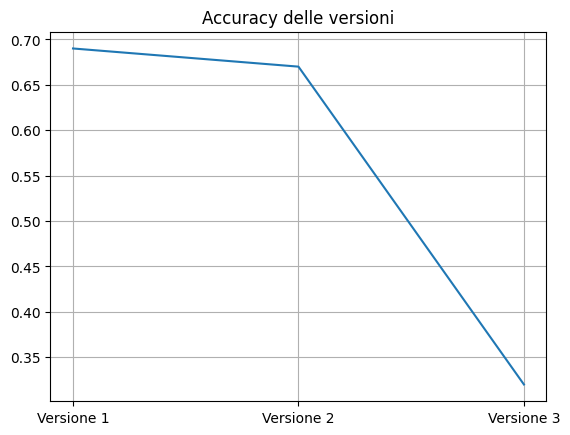

In [10]:
import matplotlib.pyplot as plt
x_plot = ["Versione 1", "Versione 2", "Versione 3"]
y_plot = [accuracy1, accuracy2, accuracy3]
plt.plot(x_plot, y_plot, label = "line 2")
plt.title('Accuracy delle versioni')
plt.grid()


## Cambio di feature
Per cercare di aumentare la accuracy, proverò ora a cambiare le feature.

### Versione 4: Uso del field "summary"

In [11]:
classifier4, accuracy4 = get_classifier_and_mean_accuracy([1.0, 5.0], field="summary", funzione_tokenize=nltk.word_tokenize)
print(accuracy4)

0.69


### Versione 5: uso dei soli aggettivi

In [12]:
def filtra_reviews(reviews):
    reviews5 = []
    for (lista_parole,classe) in reviews:
        solo_aggettivi = []
        for par in lista_parole:
            tmp = wn.synsets(par)
            if len(tmp) > 0 and tmp[0].pos() == "a":
                solo_aggettivi.append(par)
        if solo_aggettivi != []:
            reviews5.append((solo_aggettivi,classe)) 
    return reviews5

classifier5, accuracy5 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, funzione_filtra_reviews=filtra_reviews)
print(accuracy5)

0.57


### Versione 6: uso della frequency word invece della occurrence

In [13]:
def conta_parole(words):
    wfreq=[words.count(w) for w in words]
    return dict(zip(words,wfreq))

classifier6, accuracy6 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, feat_extractor=conta_parole)
accuracy6

0.64

## Uso della libreria Scikit-learn
Proverò ora a passare alla libreria "Scikit-learn". 


### Versione 7: Classificatore Support Vector Machines (SVM)
Nelle versioni viste finora, ho sempre fatto uso del classificatore Naive Bayes di nltk. Proverò ora a modificarlo, per cercare di migliorare l'accuracy.

In [14]:
# Creo il train e test set
reviews7 = getReviewData([1.0, 5.0], limite=1000)

train_data, train_target, test_data, test_target = get_train_test_data_target(reviews7)

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', svm.SVC()),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy7 = round(sum(scores)/len(scores), 2)
print(accuracy7)


0.88


### Versione 8: Grid-search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

reviews8 = getReviewData([1.0, 5.0], limite=1000)
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews8)


text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
text_clf.fit(train_data, train_target)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1)
gs_clf = gs_clf.fit(train_data, train_target)
predicted = gs_clf.predict(test_data)

scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy8 = round(sum(scores)/len(scores), 2)

print("Accuracy: ", accuracy8)

Accuracy:  0.89


### Versione 9: uso di demo_liu_hu_lexicon come feture extractor 
<mark> TODO mettere questo capitolo da un'altra parte spostare da qui

In [16]:
def mio_demo_liu_hu_lexicon(sentence):
    """ Questo codice e' lo stesso della funzione nltk.sentiment.util.demo_liu_hu_lexicon, ma: 
    - al posto di print("Positive") ho messo return {"sent":"Positive"}. Stessa cosa per "Negative" e "Neutral". 
    - Inoltre, ho permesso di dare in input alla funzione una lista di stringhe, invece che una stringa TODO scrivi meglio
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0

    if not type(sentence) is list:
        tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]
    else:
        tokenized_sent = [word.lower() for word in sentence]

    x = list(range(len(tokenized_sent)))  # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1)  # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1)  # negative
        else:
            y.append(0)  # neutral

    if pos_words > neg_words:
        return {"sent":"Positive"}
    elif pos_words < neg_words:
        return {"sent":"Negative"}
    elif pos_words == neg_words:
        return {"sent":"Neutral"}

In [17]:
classifier9, accuracy9 = get_classifier_and_mean_accuracy([1.0, 5.0],feat_extractor=mio_demo_liu_hu_lexicon, limite=10)
accuracy9

0.77

### Versione 10: Hyperlane

In [18]:
from sklearn.linear_model import SGDClassifier

# Creo il train e test set
reviews10 = getReviewData([1.0, 5.0], limite=1000)
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews10)

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy10 = round(sum(scores)/len(scores), 2)
print(accuracy10)


0.86


### Versione 11: lemmatizer invece di tokenizer

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()
def filtra_non_stop_words(reviews):
    reviews = [(re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(testo_recensione).lower()).strip(), classe) for (testo_recensione, classe) in reviews]
    reviews = [([wnl.lemmatize(parola) for parola in testo_recensione.split(" ") if parola not in stop_words], classe) for (testo_recensione,classe) in reviews]
    return reviews

classifier11, accuracy11 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_filtra_reviews=filtra_non_stop_words)
# print([ for i in "hi how are you".split(" ")])
print(accuracy11)

0.69


## Uso di XGBoost

In [20]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score

reviews12 = getReviewData([1.0, 5.0], limite=1000)
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews12)

cv = CountVectorizer(binary = True)
cv.fit(train_data)
train_transform = cv.transform(train_data)
test_transform = cv.transform(test_data)

# Trasformo i target del trainset e testset in un formato adatto a xgboost
train_target = [0 if target=="1.0" else 1 for target in train_target]
test_target = [0 if target=="1.0" else 1 for target in test_target]

## Training and Predicting
train_matrix = xgb.DMatrix(train_transform, train_target)      
test_matrix = xgb.DMatrix(test_transform, test_target)
# param = {'eta': 0.75, 'max_depth': 50, 'objective': 'binary:logitraw'}
param = {'objective': 'binary:hinge'}    
# param = {}
# binary:hinge
classifier12 = xgb.train(param, train_matrix, num_boost_round = 30)
predicted_test = classifier12.predict(test_matrix).tolist()
# predicted_test = [1 if x>0.5 else 0 for x in predicted_test]

# Accuracy
accuracy12 = accuracy_score(test_target, predicted_test)
print("Accuracy:",  accuracy12)# 0.9247195373643664

Accuracy: 0.785


## Risultati

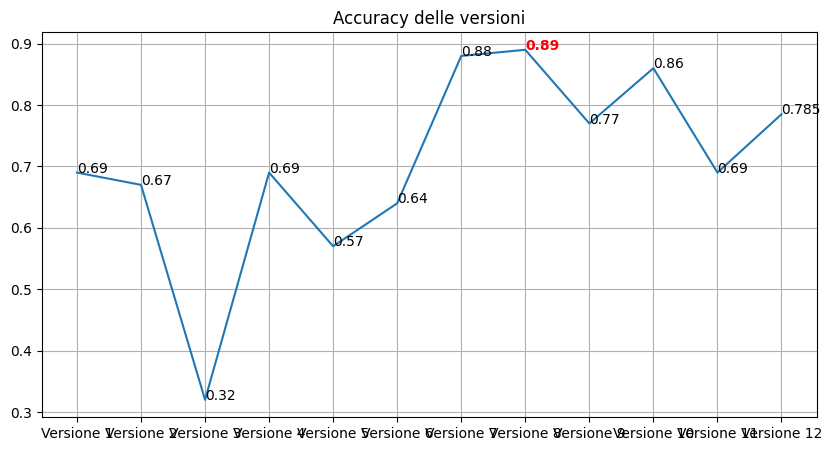

In [21]:

num_versioni = 12
x_titoli = []
y_accuracy = []
for i in range(1, num_versioni+1):
    eval("x_titoli.append('Versione "+str(i)+"')")
    eval("y_accuracy.append(accuracy"+str(i)+")")
plt.rcParams["figure.figsize"] = (10,5)

plt.plot(x_titoli, y_accuracy)
for i in range(num_versioni):
    if y_accuracy[i] == max(y_accuracy):
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]), color="red", weight='bold')
    else:
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]))

plt.title('Accuracy delle versioni')
plt.grid()
